In [2]:
import clip
import torch
from PIL import Image

/home/rajkinra23/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

In [4]:
image_id = "0400016650890"
image_name = "0400016650890_A1_0.jpg"
image = "/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/{}/{}".format(image_id, image_name)

In [5]:
image_input = clip_preprocess(Image.open(image)).unsqueeze(0).to(device)
image_features = clip_model.encode_image(image_input)
print(image_features.size())

torch.Size([1, 512])


In [6]:
def get_embedding(image):
    image_input = clip_preprocess(Image.open(image)).unsqueeze(0).to(device)
    image_features = clip_model.encode_image(image_input)
    return image_features

In [8]:
# Compute distance between two images
def similarity(a, b):
    a_embedding = get_embedding(a)
    b_embedding = get_embedding(b)
    # print(a_embedding, b_embedding)
    # print(a_embedding - b_embedding)
    dist = (a_embedding - b_embedding).pow(2).sum(1).sqrt()
    return dist

In [9]:
def embedding_similarity(a, b):
    dist = (a - b).pow(2).sum(1).sqrt()
    return float(dist)

In [10]:
image_template = "/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/{}/{}"
a = image_template.format("0400016650890", "0400016650890_A1_0.jpg")
b = image_template.format("0400016650890", "0400016650890_A2_0.jpg")
c = image_template.format("0400017081918", "0400017081918_A0_0.jpg")
d = image_template.format("0400017081918", "0400017081918_A0_0.jpg")
e = image_template.format("0400015606460", "0400015606460_A3_0.jpg")
# print(similarity(a, b))
# print(similarity(a, c))
# print(similarity(d, e))
# print(similarity(a, d))

In [11]:
import random
import os

# Take a random sample of images and see how the similarity really works
train_dir = "/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/"
image_ids = set(os.listdir(train_dir))

# Populate some random images
m = {}
images = []
for image_id in image_ids:
    root = os.path.join(train_dir, image_id)
    for image in os.listdir(root):
        images.append(os.path.join(root, image))
        m[os.path.join(root, image)] = image_id
print(len(images))

25025


In [11]:
# Compute similarity
similarity = []
for a in embeddings:
    for b in embeddings:
        if a != b and m[a] != m[b]:
            similarity.append((embedding_similarity(embeddings[a], embeddings[b]), a, b))

In [1]:
# Start connecting to redis to get storage
# Reference doc - https://github.com/RedisAI/vecsim-demo/blob/master/VisualSearch1k.ipynb

import numpy as np
import random
import numpy as np
import pandas as pd
import time
from redis import Redis
from redis.commands.search.field import VectorField
from redis.commands.search.field import TextField
from redis.commands.search.field import TagField
from redis.commands.search.query import Query
from PIL import Image

r = Redis(host = 'localhost', port = 6379)
vector_field = "vector"
dim = 512
print(r.ping())

# Util function to create hnsw index
def create_hnsw_index(name, vector_dimensions=512):
    try:
        schema = []
        schema.append(VectorField(name, "HNSW", {"TYPE": "FLOAT32", "DIM": vector_dimensions, "DISTANCE_METRIC": "L2"}))
        schema.append(TextField("item_name"))
        r.ft().create_index(schema)
    except Exception as e:
        print("Creating index failed; it probably exists?")
        print("Exception: {}".format(e))
    
PRODUCT_IMAGE_VECTOR_FIELD = 'product_image_vector'
ITEM_NAME_FIELD = "item_name"
IMAGE_VECTOR_DIMENSION = 512

# Create the hnsw index
create_hnsw_index(PRODUCT_IMAGE_VECTOR_FIELD, IMAGE_VECTOR_DIMENSION)

True
Creating index failed; it probably exists?
Exception: Index already exists


In [13]:
keys = r.keys()
print(keys[:10])
key = '/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/0400017557668/0400017557668_A1_0.jpg'
print(bytes(key, 'utf-8'))
print(bytes(key, 'utf-8') in keys)
r.delete(bytes(key, 'utf-8'))

[b'/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/0400017557668/0400017557668_A1_0.jpg', b'/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/0400017622599/0400017622599_A1_0.jpg', b'/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/0400017852841/0400017852841_A4_0.jpg', b'/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/0400018168664/0400018168664_A2_0.jpg', b'/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/0400017530749/0400017530749_A4_0.jpg', b'/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/0400016768744/0400016768744_A4_0.jpg', b'/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/0400018046892/0400018046892_A1_0.jpg', b'/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/0400018510210/0400018510210_A3_0.jpg', b'/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/0400016200419/0400016200419_A3_0.jpg', b'/home/rajkinra23/git/drip_vision/data/embeddings_dataset/trai

1

In [14]:
# Write data to redis
print(len(images))
for image in images:
    embedding = get_embedding(image).cpu().detach().numpy().astype(np.float32).tobytes()
    key = image
    product_id = m[image]
    item_metadata = {
        PRODUCT_IMAGE_VECTOR_FIELD: embedding,
        ITEM_NAME_FIELD: product_id
    }
    r.hset(key, mapping=item_metadata)

25025


KeyboardInterrupt: 

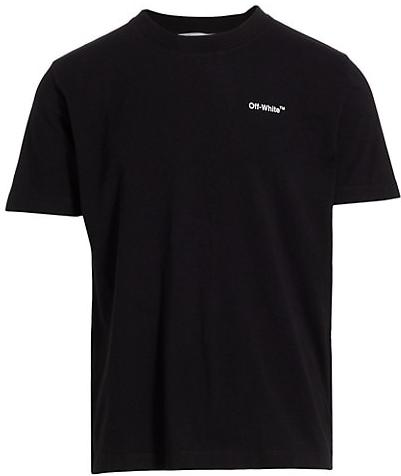

0 0400015606415


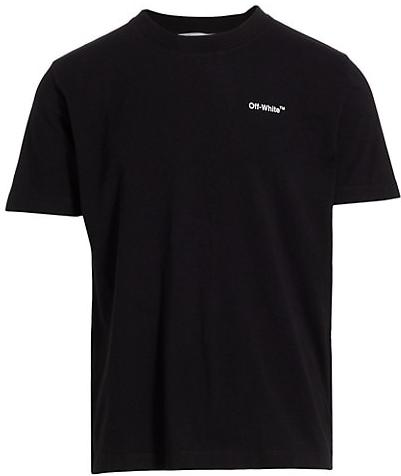

10.1833553314 0400014952365


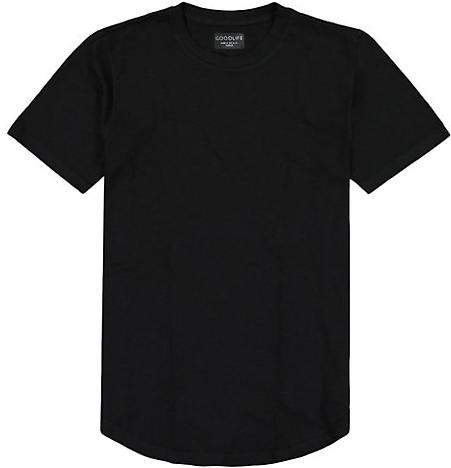

10.4705944061 0400017353037


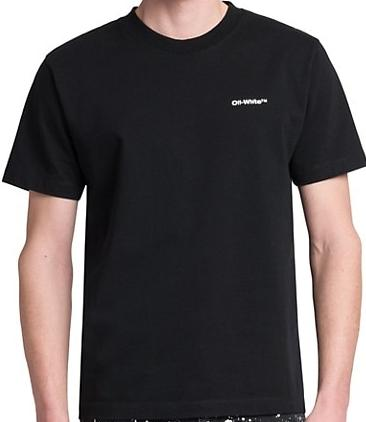

11.0766792297 0400017353037


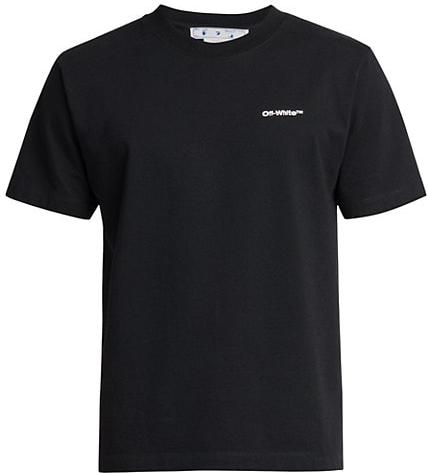

11.1168670654 0400014581525


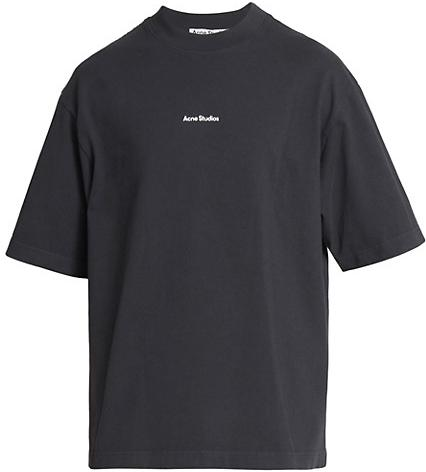

11.4496259689 0400018047176


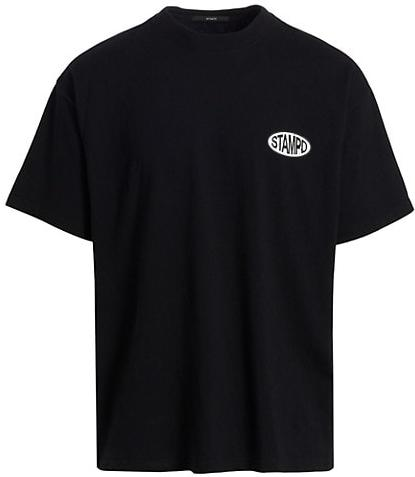

11.4496259689 0400018047176


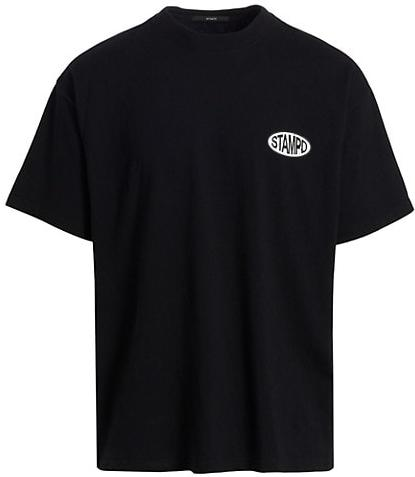

11.4537782669 0400014983470


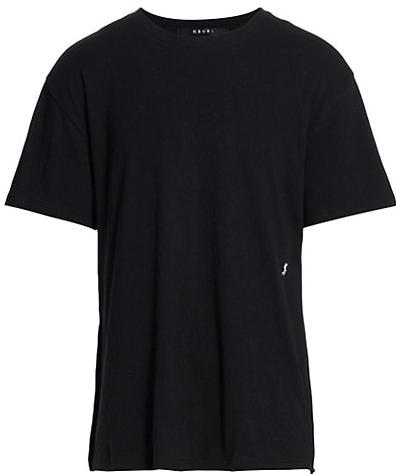

12.2670278549 0400014986140


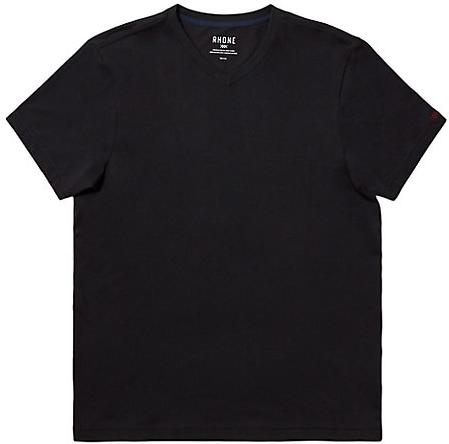

12.7329492569 0400017081369


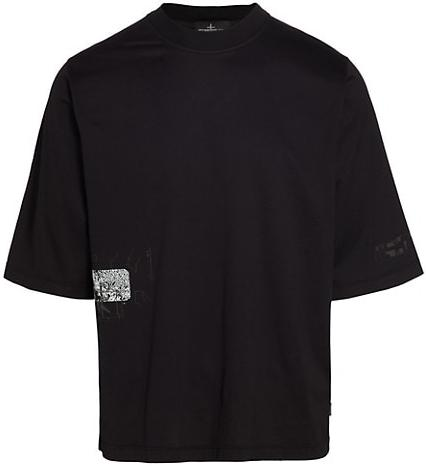

12.7789964676 0400015606460


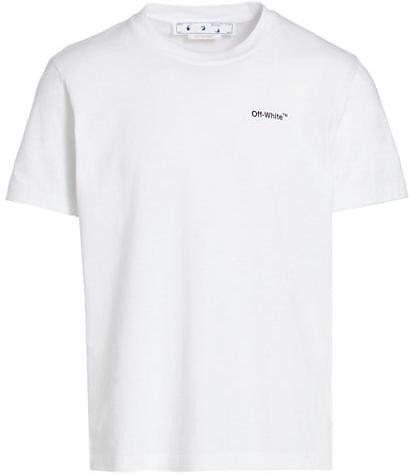

13.0016422272 0400017567516


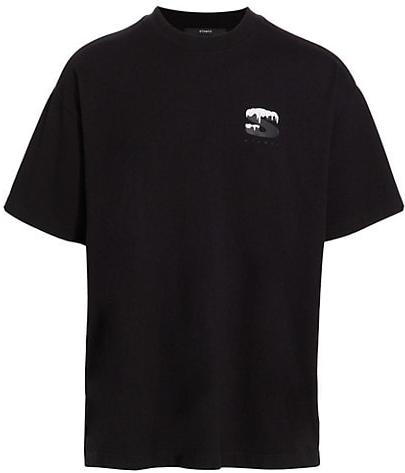

13.1829223633 0400097466401


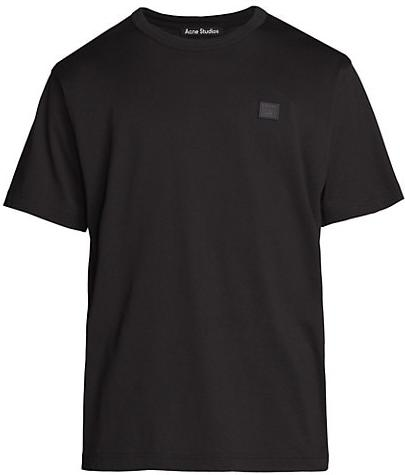

13.8640832901 0400017055022


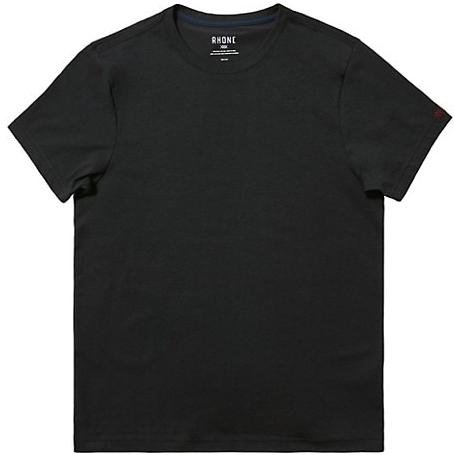

13.9286193848 0400095747052


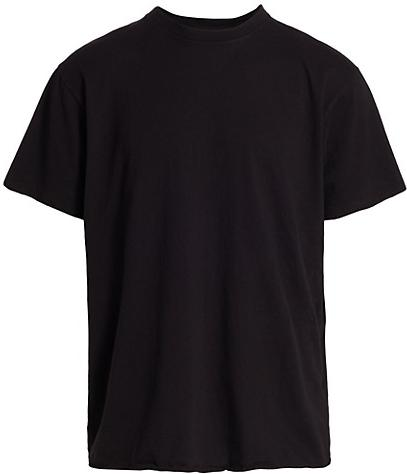

14.2128562927 0400015606293


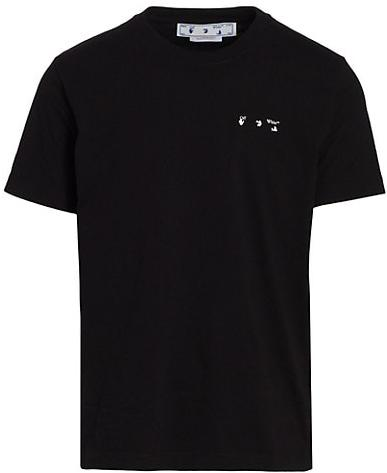

14.7568054199 0400015154983


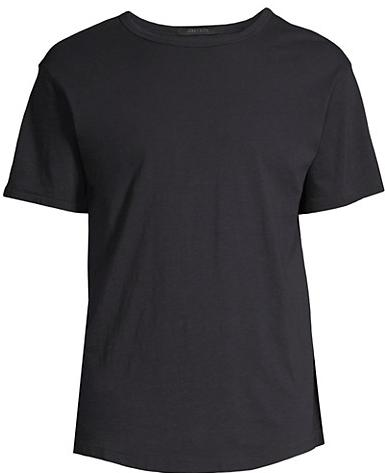

14.9429597855 0400014664016


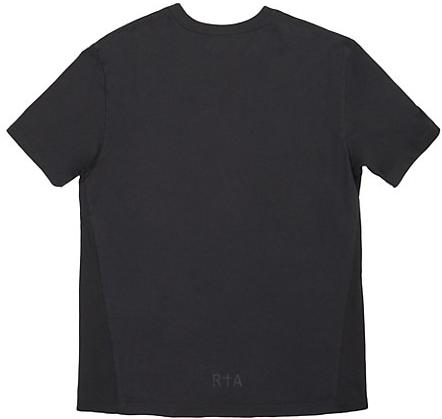

14.953915596 0400018508959


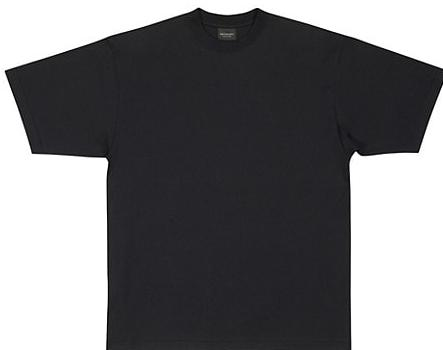

15.206407547 0400013596138


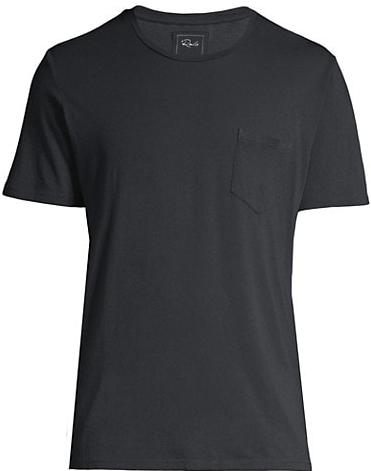

15.2618761063 0400018084165


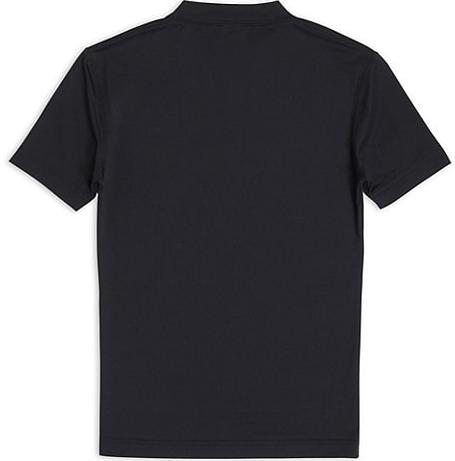

15.6778621674 0400015712914


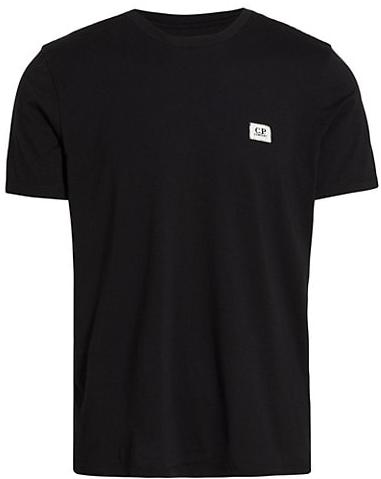

15.7506694794 0400016604333


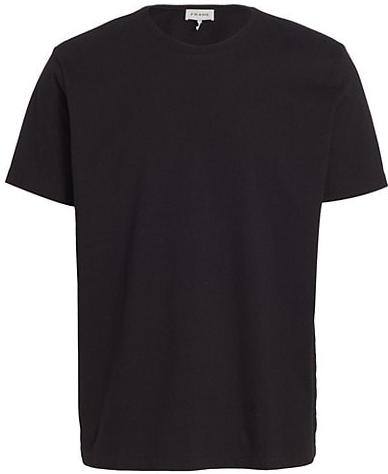

15.7687416077 0400017512094


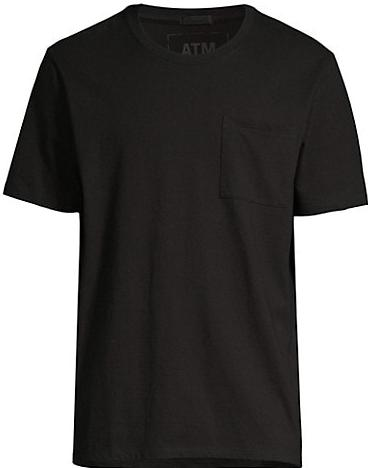

16.0212364197 0400017342875


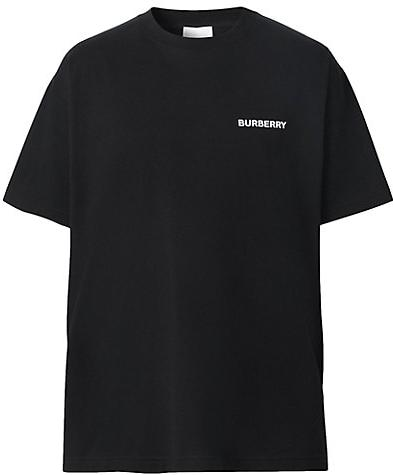

16.1791782379 0400014372339


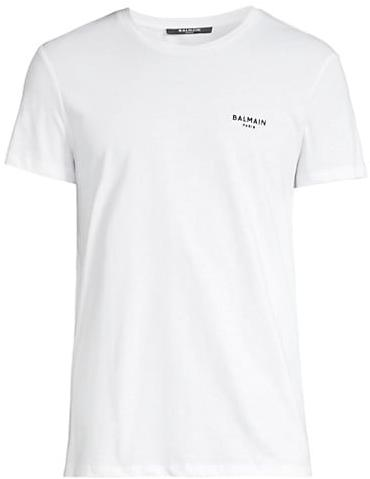

16.3355998993 0400018047172


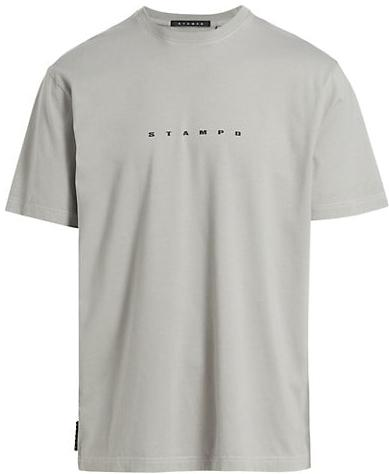

16.3355998993 0400018047172


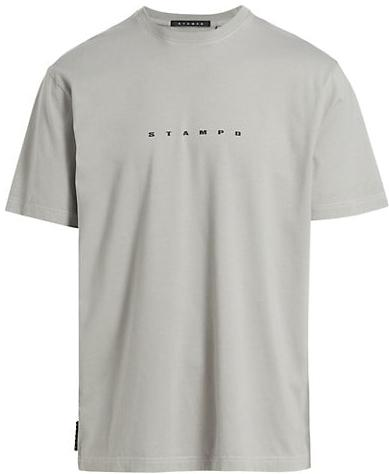

16.480846405 0400018247713


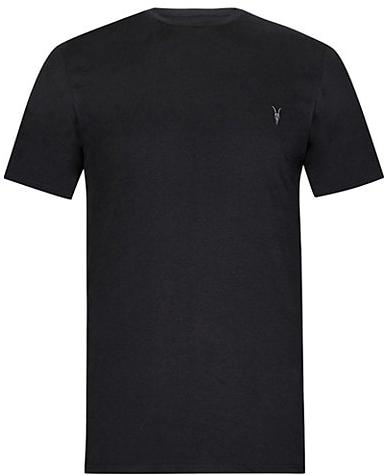

16.6362934113 0400014510226


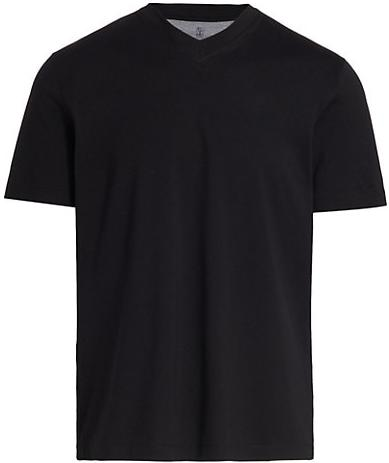

16.6799125671 0400018417428


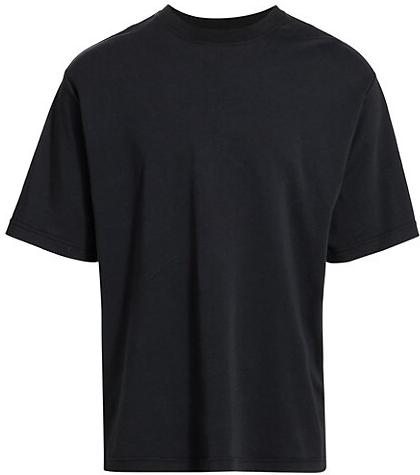

16.8128948212 0400014633003


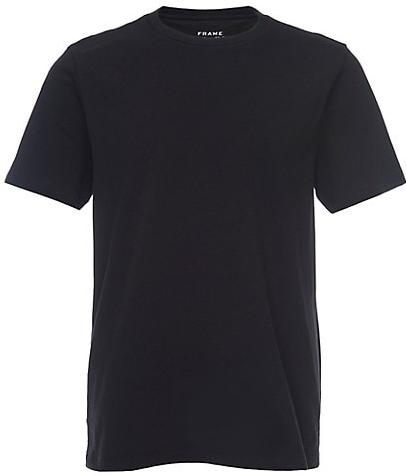

16.829624176 0400018075931


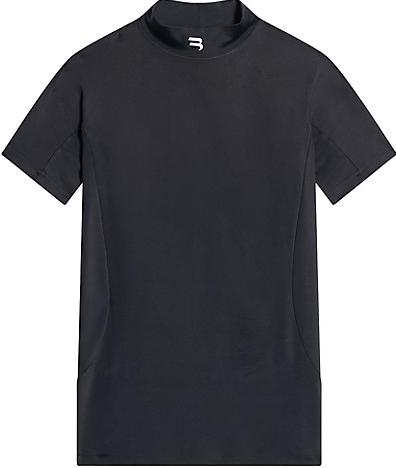

16.8755493164 0400018646664


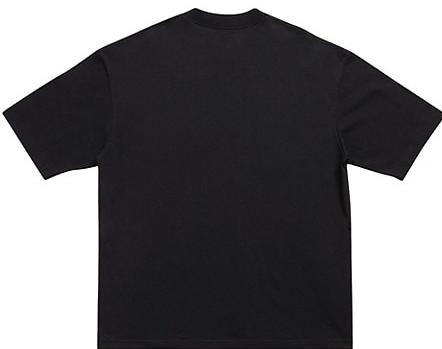

16.8997917175 0400014510207


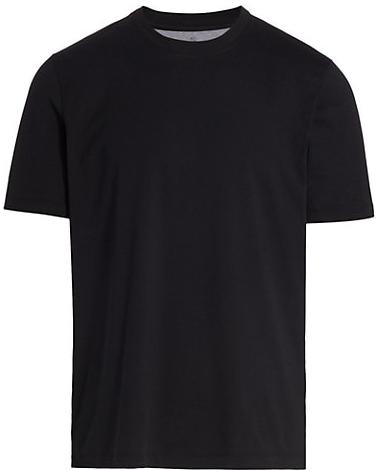

16.9846534729 0400018083962


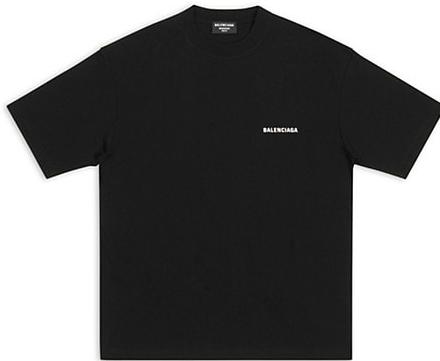

17.124130249 0400013438663


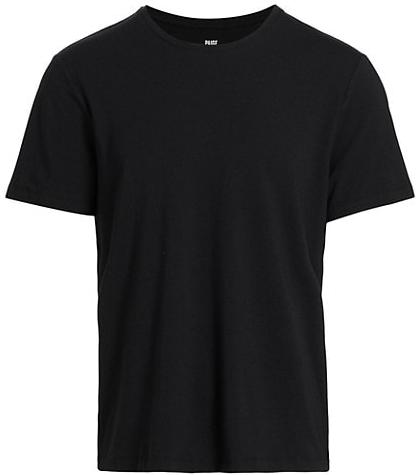

17.1463069916 0400017384377


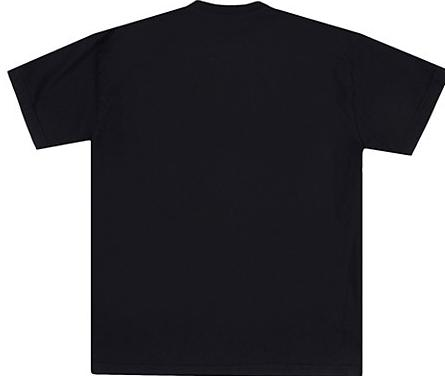

17.1526985168 0400015713099


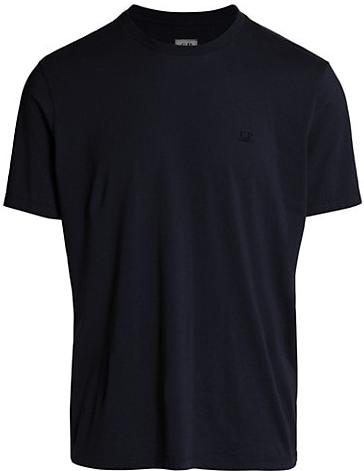

17.2575836182 0400014581525


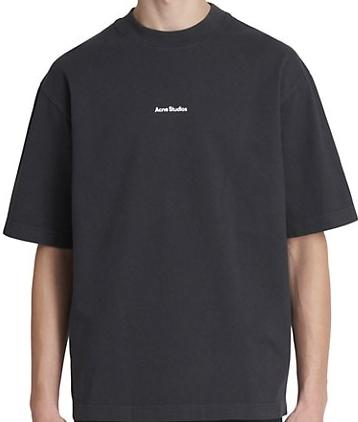

17.2595176697 0400014581525


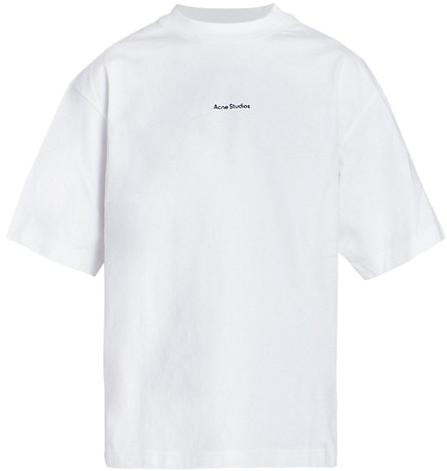

17.315454483 0400015685085


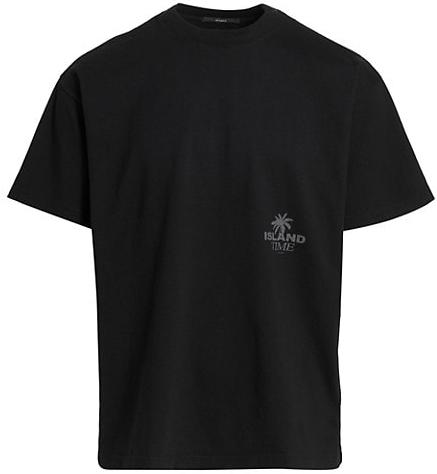

17.382982254 0400009240035


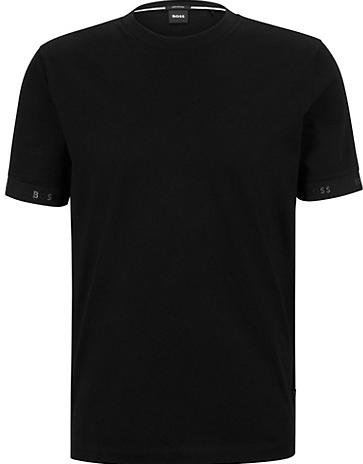

17.3926773071 0400017439948


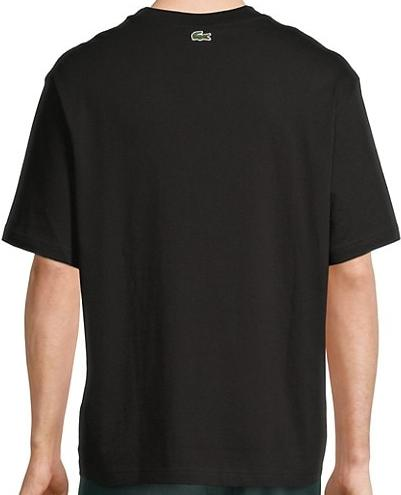

17.5485515594 0400018477916


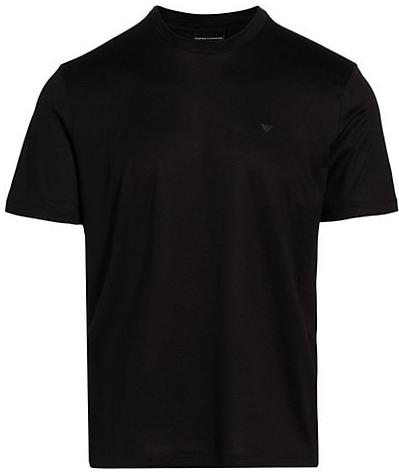

17.6227779388 0400009240073


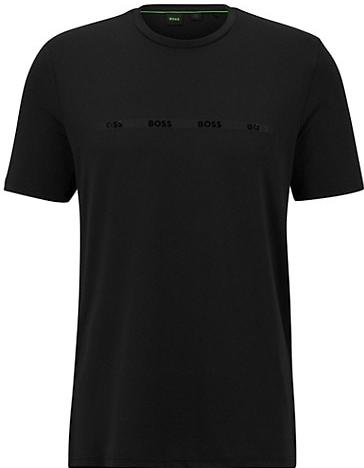

17.6621055603 0400013474226


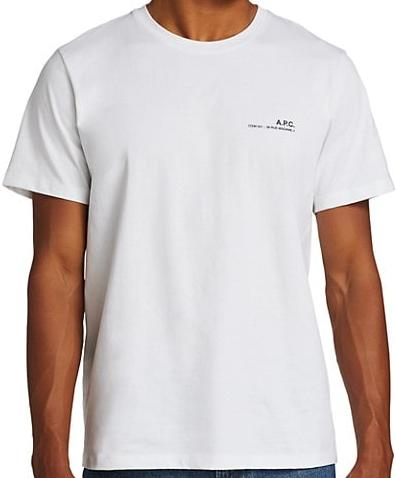

17.6701259613 0400015596509


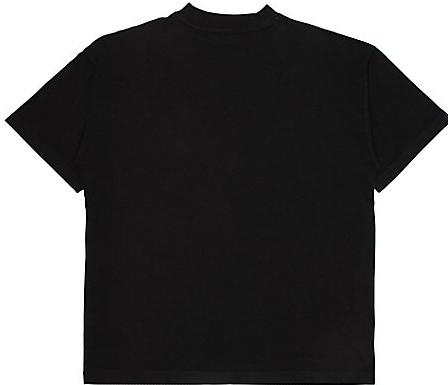

17.6705322266 0400018572671


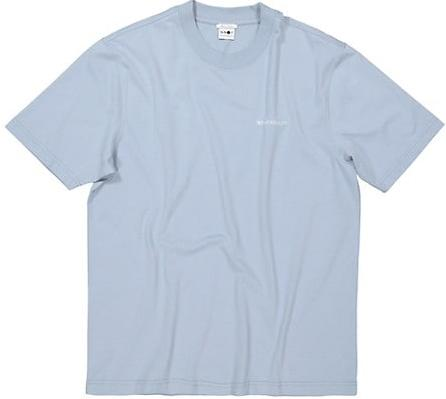

17.6847553253 0400014581525


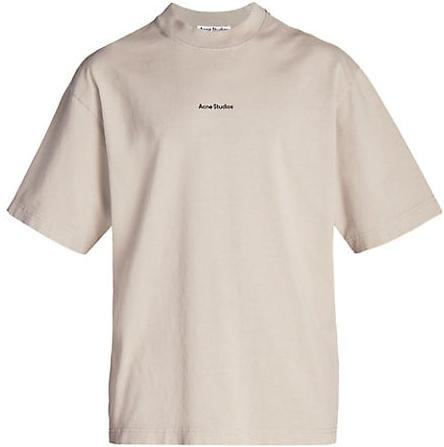

In [23]:
# Query to find the most similar image
topK=50
EF_RUNTIME=10
test_image = '/home/rajkinra23/git/drip_vision/data/embeddings_dataset/train/0400015606415/0400015606415_A0_0.jpg'
query_vector = get_embedding(test_image).cpu().detach().numpy().astype(np.float32).tobytes()
q = Query(f'*=>[KNN {topK} @{PRODUCT_IMAGE_VECTOR_FIELD} $vec_param EF_RUNTIME {EF_RUNTIME} AS vector_score]').sort_by('vector_score').paging(0,topK).return_fields('vector_score','item_name').dialect(2)
params_dict = {"vec_param": query_vector}


display(Image.open(test_image))

#Execute the query
results = r.ft().search(q, query_params = params_dict)
docs = r.ft().search(q, params_dict).docs

#Print similar products found
for product in results.docs:
    print(product.vector_score, product.item_name)
    display(Image.open(product.id))